In [59]:
%matplotlib inline

# typical sigpy and numpy imports
import sigpy
import numpy as np
import sigpy.mri as mr
import sigpy.mri.rf as rf # importing our rf tools separately
import sigpy.plot as pl

# to assist with importing data, we will also import scipy
import scipy.io as sio
import scipy.ndimage as nd

import matplotlib.pyplot as mplib

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from PIL import Image

In [60]:
def pTx_pulse_design(image, resample, type, sigma):

    
    if(type=="png"):
        # downsize the image with an ANTIALIAS filter (gives the highest quality)
        if(resample==True):
            image = image.resize((32,32), Image.LANCZOS)
    
    
        d = np.flipud(image).mean(axis=-1)


    else:
        d = image
    
    d = (d - np.amin(d))/(np.amax(d) - np.amin(d))

    dim_x = d.shape[0] # Size of image
    dim_y = d.shape[1]
    Nc = 8 # Number of pTx channels
    sens_shape = [Nc, dim_x, dim_y] # Sensitivity map shape: one per channel
    img_shape = [dim_x, dim_y] # Size of 2D image

    #pl.ImagePlot(d, title='Target Excitation Pattern', colormap="gray")

    d = nd.gaussian_filter(d, sigma)
    d = d.astype(complex)
    #pl.ImagePlot(d, title='Blurred Target', colormap="gray")

    sens = mr.birdcage_maps(sens_shape)
    #pl.ImagePlot(sens, z=0, mode= "m" ,title='Sensitivity maps')

    fov =   0.55 # FOV in m
    gts =   6.4E-6 # hardware dwell time, s
    gslew =   150 # gradient slew rate in mT/m/ms
    gamp =  30 # maximum gradient amplitude in mT/m
    R =   1/3 # degree of undersampling of trajectory
    res = 0.025# in m

    # construct a trajectory
    g, k, t, s = rf.spiral_arch(fov/R,res,gts,gslew,gamp)# insert function to design a trajectory

    #Note that this trajectory is a spiral-out trajectory. 
    #Simply time-reverse it to create a spiral-in.

    # do so here: 
    k = k[::-1]
    g = g[::-1]


    #mplib.figure()
    #mplib.plot(k[:,0],k[:,1], color='orange')
    #mplib.title('Constant density spiral-in trajectory kx and ky')
    #mplib.figure()
    #mplib.plot(g[:])
    #mplib.title('Gradient waveforms')

    pulses = rf.stspa(d, sens, k, gts, alpha=0.01, max_iter=10, tol=1e-7, phase_update_interval=10, explicit=False)# insert function to perform small-tip spatial domain design

    modes = np.array(["m", "p", "r", "i"])
    modes_names = np.array(["magnitude", "phase", "real part", "imaginary part"])
    #pl.LinePlot(pulses[slice], x=-1 ,mode= modes[mode_ind] ,title='8 pulse channels mode='+ modes_names[mode_ind])

    # insert the SENSE() linop, and take its adjoint
    A = mr.linop.Sense(sens, coord=k, ishape=d.shape).H

    # apply the linop A to your pulses
    m = A*pulses

    #pl.ImagePlot(m, title = 'Mxy')

    # simulation code is written below: 
    x, y = np.meshgrid(np.linspace(fov/2, -fov/2, dim_x), np.linspace(fov/2, -fov/2, dim_y))
    spatial = np.fliplr(np.concatenate((np.reshape(x, (dim_x*dim_y, 1)), np.reshape(y, (dim_x*dim_y, 1))), axis=1))
    gam = 42580 # Hz/mT
    a, b, m, mz = rf.abrm_ptx(pulses/33, spatial, g * gam * gts * 2 * np.pi, gts, fmap=None, sens=sens)

    pl.ImagePlot(np.reshape(2*a*np.conj(b),img_shape), mode='m', title=('Mxy'), colormap="gray", save_basename="Figure")
    pl.ImagePlot(np.reshape(1-2*np.absolute(b)**2,img_shape), mode='m', title=('Mz'), colormap="gray", save_basename="Figure")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_23824\2775604231.py:7: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((32,32), Image.LANCZOS)


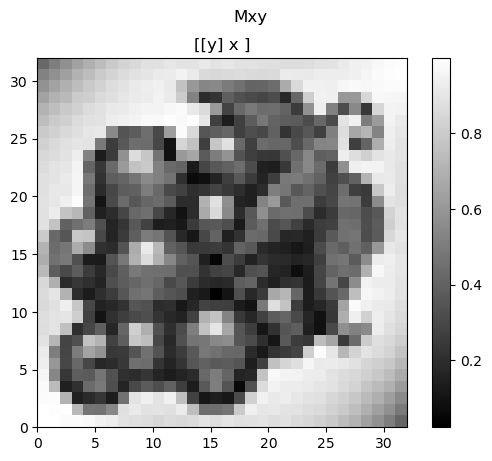

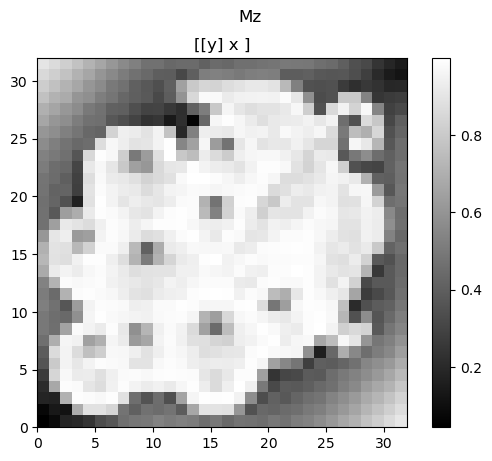

In [61]:
image = Image.open('uva.png')

pTx_pulse_design(image, resample=True, type="png", sigma=0.0)

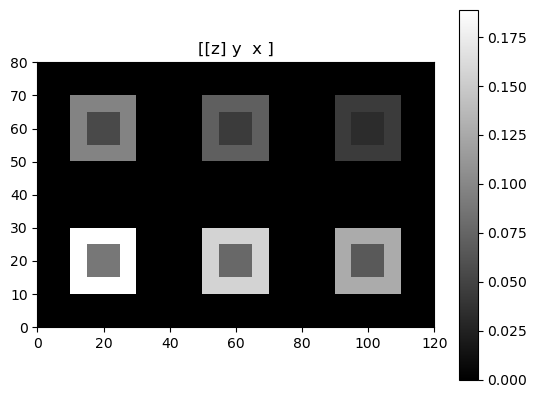

In [112]:
def IR(T1,T2,TE,TR,TI):
    S = -(1-2*np.exp(-TI/T1)+ np.exp(-TR/T1))*np.exp(-TE/T2)
    return S

def phantom_creation(T1_1,T1_2,T2_1,T2_2,TE,TR,TI):
    phantom = np.zeros((40,40))
    phantom[10:30, 10:30] = IR(T1_1,T2_1,TE,TR,TI)
    phantom[15:25, 15:25] = IR(T1_2,T2_2,TE,TR,TI)
    return phantom

T1_1, T1_2, T2_1, T2_2 = 1080, 3500, 100, 109
TE, TR = 100, 1000
TIs = np.array([50,100,150,200,250,300])


phantoms = np.array([phantom_creation(T1_1,T1_2,T2_1,T2_2,TE,TR,TI) for TI in TIs])

pl.ImagePlot(phantoms, z=0, colormap="gray")

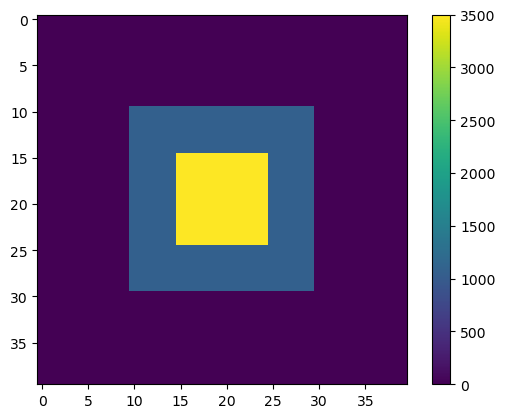

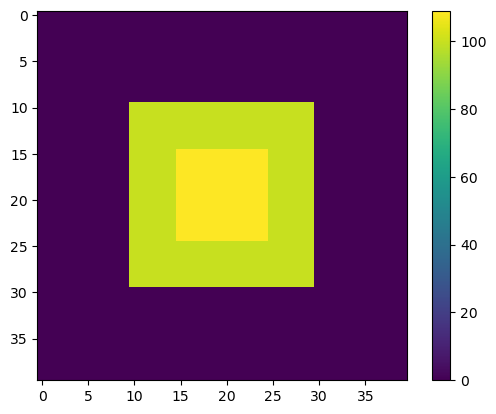

In [113]:
from scipy.optimize import curve_fit

def IR_fit(TI,E1,E2):
    S = -(1-2*np.exp(-TI*E1)+ np.exp(-TR*E1))*np.exp(-TE*E2)
    return S

T1_map = np.zeros(phantoms[0].shape)
T2_map = np.zeros(phantoms[0].shape)

for row in range(phantoms[0].shape[0]):
    for column in range(phantoms[0].shape[1]):
        if(phantoms[:,row,column].all() >= 0.01):
            popt, pcov = curve_fit(IR_fit, TIs, phantoms[:,row,column], p0=[0.01,0.01], maxfev=10000)
            T1_map[row,column] = 1/popt[0]
            T2_map[row,column] = 1/popt[1]

mplib.figure()
mplib.imshow(T1_map)
mplib.colorbar()
mplib.figure()
mplib.imshow(T2_map)
mplib.colorbar()

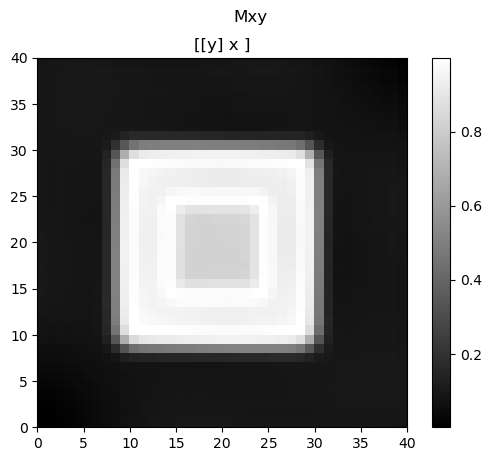

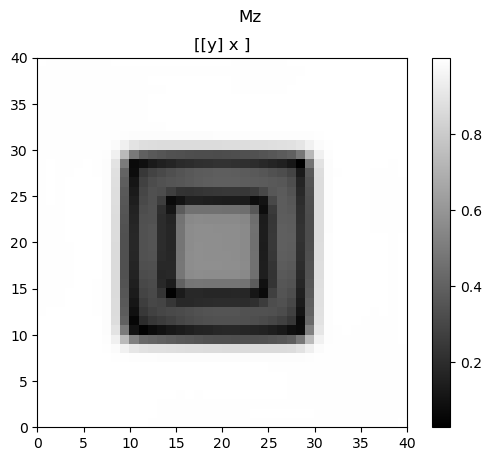

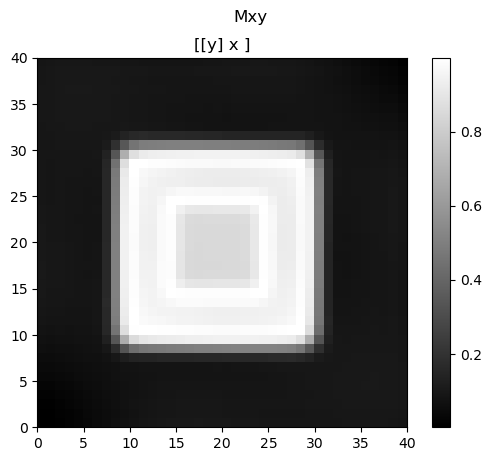

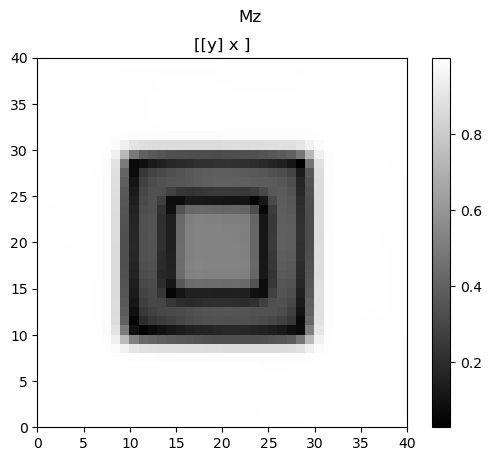

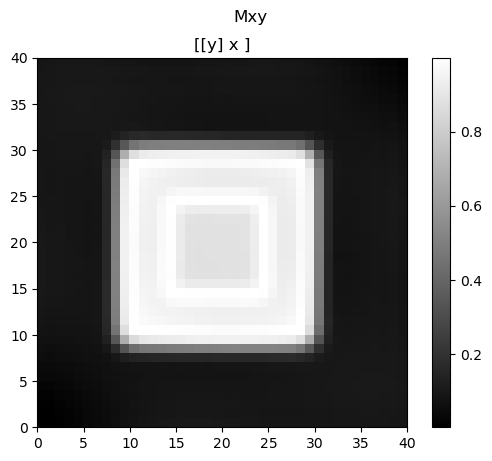

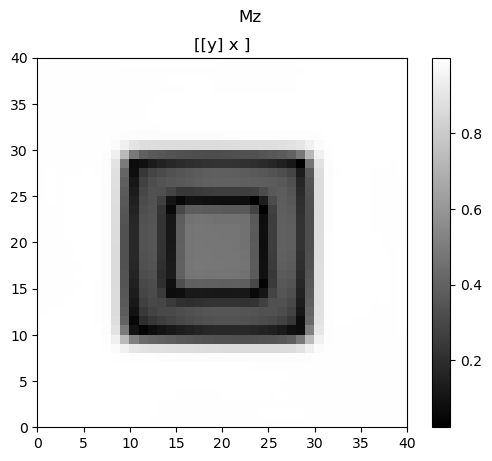

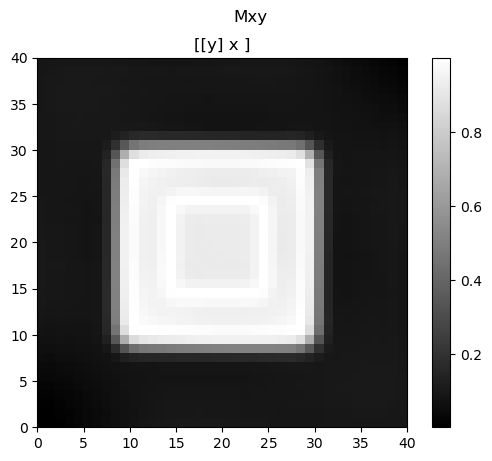

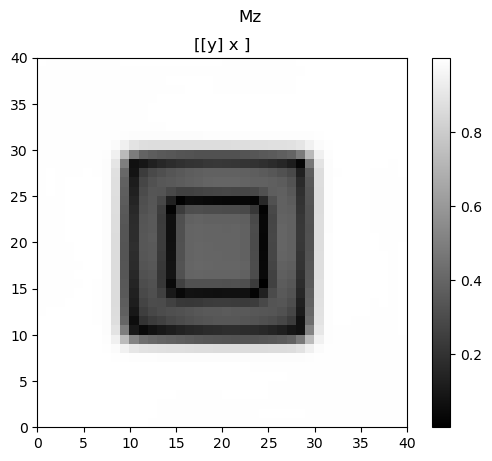

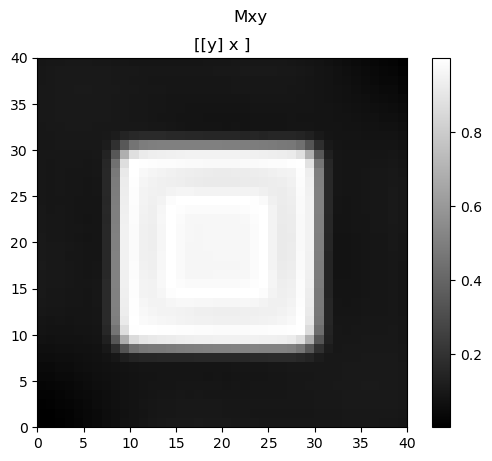

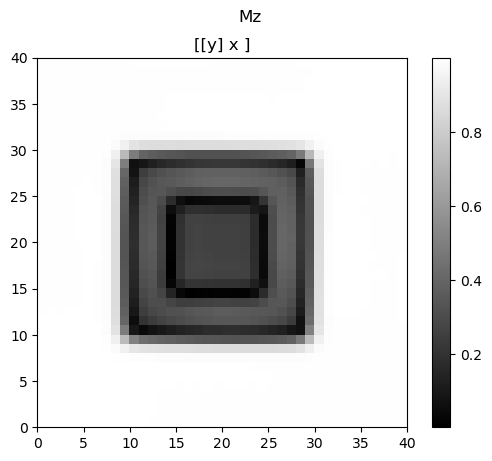

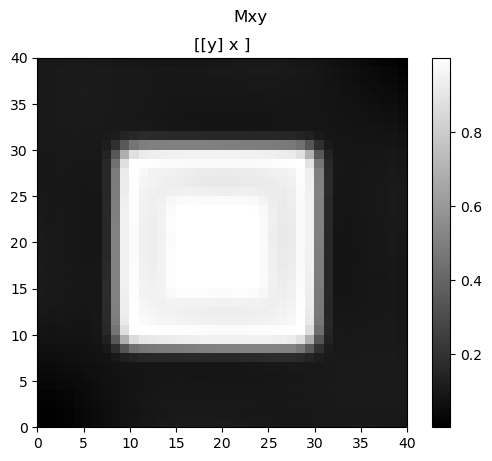

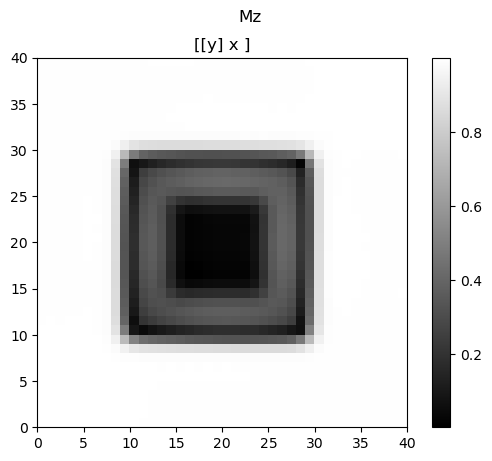

In [70]:
for phantom in phantoms:
    pTx_pulse_design(phantom, resample=False, type="array", sigma=1.0)